In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
from tableone import TableOne
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import mahalanobis
from scipy.stats import ttest_rel
import statsmodels.api as sm
from statsmodels.formula.api import glm
from statsmodels.stats.contingency_tables import mcnemar

from statsmodels.stats.weightstats import DescrStatsW
from statsmodels.genmod.families import Binomial
import matplotlib.pyplot as plt
# Load the dataset (You'll need a compatible .sav file reader, such as pyreadstat)
import pyreadstat

In [9]:
# Helper functions for expit and logit (same as in R)
expit = lambda x: 1 / (1 + np.exp(-x))
logit = lambda p: np.log(p) - np.log(1 - p)

In [2]:
# read data located inside a folder data inside same repository named rhc.csv using read csv function
rhc_df  = pd.read_csv('data/rhc.csv')
# source https://hbiostat.org/data/repo/rhc.csv


In [3]:

# Simplify data (this can be customized based on your exact file structure)
ARF = (rhc_df['cat1'] == 'ARF').astype(int)
CHF = (rhc_df['cat1'] == 'CHF').astype(int)
Cirr = (rhc_df['cat1'] == 'Cirrhosis').astype(int)
colcan = (rhc_df['cat1'] == 'Colon Cancer').astype(int)
Coma = (rhc_df['cat1'] == 'Coma').astype(int)
COPD = (rhc_df['cat1'] == 'COPD').astype(int)
lungcan = (rhc_df['cat1'] == 'Lung Cancer').astype(int)
MOSF = (rhc_df['cat1'] == 'MOSF w/Malignancy').astype(int)
sepsis = (rhc_df['cat1'] == 'MOSF w/Sepsis').astype(int)
female = (rhc_df['sex'] == 'Female').astype(int)
died = (rhc_df['death'] == 'Yes').astype(int)
age = rhc_df['age']
treatment = (rhc_df['swang1'] == 'RHC').astype(int)
meanbp1 = rhc_df['meanbp1']

# Create new dataset
mydata = pd.DataFrame({
    'ARF': ARF, 'CHF': CHF, 'Cirr': Cirr, 'colcan': colcan,
    'Coma': Coma, 'lungcan': lungcan, 'MOSF': MOSF, 'sepsis': sepsis,
    'age': age, 'female': female, 'meanbp1': meanbp1, 'treatment': treatment, 'died': died
})

# Define covariates
xvars = ['ARF', 'CHF', 'Cirr', 'colcan', 'Coma', 'lungcan', 'MOSF', 'sepsis', 'age', 'female', 'meanbp1']

# Table 1: Summary table of the covariates stratified by treatment
table1 = TableOne(data=mydata, columns=xvars, categorical=xvars, groupby='treatment', pval=False)
print(table1.tabulate(tablefmt="fancy_grid"))

╒════════════════╤═══════════╤═══════════╤═════════════╤═════════════╤══════════════╕
│                │           │ Missing   │ Overall     │ 0           │ 1            │
╞════════════════╪═══════════╪═══════════╪═════════════╪═════════════╪══════════════╡
│ n              │           │           │ 5735        │ 3551        │ 2184         │
├────────────────┼───────────┼───────────┼─────────────┼─────────────┼──────────────┤
│ ARF, n (%)     │ 0         │           │ 3245 (56.6) │ 1970 (55.5) │ 1275 (58.4)  │
├────────────────┼───────────┼───────────┼─────────────┼─────────────┼──────────────┤
│                │ 1         │           │ 2490 (43.4) │ 1581 (44.5) │ 909 (41.6)   │
├────────────────┼───────────┼───────────┼─────────────┼─────────────┼──────────────┤
│ CHF, n (%)     │ 0         │           │ 5279 (92.0) │ 3304 (93.0) │ 1975 (90.4)  │
├────────────────┼───────────┼───────────┼─────────────┼─────────────┼──────────────┤
│                │ 1         │           │ 456 (8.0)  

In [4]:

# Greedy matching on Mahalanobis distance
# Scale the variables to standardize them before computing Mahalanobis distance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(mydata[xvars])

In [5]:
# Compute pairwise Mahalanobis distances between treatment and control
cov_matrix = np.cov(X_scaled, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

def mahalanobis_distance(x, y, inv_cov):
    return mahalanobis(x, y, inv_cov)

treated = mydata[mydata['treatment'] == 1]
control = mydata[mydata['treatment'] == 0]


In [7]:
# Calculate distances between treated and controls
distances = pairwise_distances(treated[xvars], control[xvars], metric='mahalanobis', VI=inv_cov_matrix)

# For simplicity, match each treated unit to the closest control
treated_indices = np.arange(len(treated))
control_indices = np.argmin(distances, axis=1)

# Reset indices for both treated and control to avoid duplicate index issues
treated_reset = treated.reset_index(drop=True)
control_matched_reset = control.iloc[control_indices].reset_index(drop=True)

# Create the matched dataset by concatenating treated and matched control groups
matched = pd.concat([treated_reset, control_matched_reset], axis=0).reset_index(drop=True)

# Get Table 1 for the matched data
matched_table1 = TableOne(data=matched, columns=xvars, categorical=xvars, groupby='treatment', pval=False, smd=True)
print(matched_table1.tabulate(tablefmt="fancy_grid"))


╒════════════════╤═══════════╤═══════════╤══════════════╤══════════════╤══════════════╤═════════════╕
│                │           │ Missing   │ Overall      │ 0            │ 1            │ SMD (0,1)   │
╞════════════════╪═══════════╪═══════════╪══════════════╪══════════════╪══════════════╪═════════════╡
│ n              │           │           │ 4368         │ 2184         │ 2184         │             │
├────────────────┼───────────┼───────────┼──────────────┼──────────────┼──────────────┼─────────────┤
│ ARF, n (%)     │ 0         │           │ 2340 (53.6)  │ 1065 (48.8)  │ 1275 (58.4)  │ 0.194       │
├────────────────┼───────────┼───────────┼──────────────┼──────────────┼──────────────┼─────────────┤
│                │ 1         │           │ 2028 (46.4)  │ 1119 (51.2)  │ 909 (41.6)   │             │
├────────────────┼───────────┼───────────┼──────────────┼──────────────┼──────────────┼─────────────┤
│ CHF, n (%)     │ 0         │           │ 4028 (92.2)  │ 2053 (94.0)  │ 1975 (90.

In [ ]:

# Outcome analysis: Paired t-test
y_trt = matched['died'][matched['treatment'] == 1]
y_con = matched['died'][matched['treatment'] == 0]

# Pairwise difference
diffy = y_trt.values - y_con.values

# Paired t-test
t_stat, p_value = ttest_rel(y_trt, y_con)
print(f"Paired t-test: t-statistic = {t_stat}, p-value = {p_value}")


Paired t-test: t-statistic = 3.105213905280237, p-value = 0.001925831533689886


In [ ]:

# McNemar test
contingency_table = np.array([[973, 513], [395, 303]])
result = mcnemar(contingency_table)
print(f"McNemar test: statistic = {result.statistic}, p-value = {result.pvalue}")


McNemar test: statistic = 395.0, p-value = 0.00010114541557317633


In [ ]:

##########################
# Propensity score matching
##########################

# Fit a logistic regression for propensity score
psmodel = sm.Logit(mydata['treatment'], sm.add_constant(mydata[xvars])).fit()
print(psmodel.summary())

# Create propensity score
mydata['pscore'] = psmodel.predict(sm.add_constant(mydata[xvars]))

# Perform greedy matching based on logit(PS) with caliper
logit_ps = np.log(mydata['pscore'] / (1 - mydata['pscore']))
ps_distances = pairwise_distances(logit_ps[mydata['treatment'] == 1].values.reshape(-1, 1),
                                  logit_ps[mydata['treatment'] == 0].values.reshape(-1, 1))

Optimization terminated successfully.
         Current function value: 0.608861
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              treatment   No. Observations:                 5735
Model:                          Logit   Df Residuals:                     5723
Method:                           MLE   Df Model:                           11
Date:                Thu, 17 Oct 2024   Pseudo R-squ.:                 0.08368
Time:                        13:50:19   Log-Likelihood:                -3491.8
converged:                       True   LL-Null:                       -3810.7
Covariance Type:            nonrobust   LLR p-value:                1.161e-129
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7300      0.200     -3.654      0.000      -1.122      -0.338
ARF            1.2932      0.

In [ ]:
# Perform greedy matching based on logit(PS) with caliper
logit_ps_treated = logit_ps[mydata['treatment'] == 1].values.reshape(-1, 1)
logit_ps_control = logit_ps[mydata['treatment'] == 0].values.reshape(-1, 1)

# Compute distances between treated and control based on logit of PS
ps_distances = pairwise_distances(logit_ps_treated, logit_ps_control)

# Set the caliper distance (maximum allowable difference)
caliper = 0.2

# Prepare lists to hold matched indices
matched_treated_indices = []
matched_control_indices = []

# For each treated unit, find the closest control within the caliper
for treated_idx in range(ps_distances.shape[0]):
    # Get distances for the current treated unit to all controls
    control_distances = ps_distances[treated_idx]
    
    # Find control indices within the caliper
    valid_control_indices = np.where(control_distances <= caliper)[0]
    
    if len(valid_control_indices) > 0:
        # Among valid control indices, find the one with the smallest distance
        closest_control_idx = valid_control_indices[np.argmin(control_distances[valid_control_indices])]
        
        # Append the treated and control indices to the match list
        matched_treated_indices.append(treated_idx)
        matched_control_indices.append(closest_control_idx)

# Now create the matched dataset using the indices
treated_matched = mydata[mydata['treatment'] == 1].iloc[matched_treated_indices].reset_index(drop=True)
control_matched = mydata[mydata['treatment'] == 0].iloc[matched_control_indices].reset_index(drop=True)

# Combine treated and matched control data, and reset index to avoid duplicate index values
matched_ps = pd.concat([treated_matched, control_matched]).reset_index(drop=True)

# Generate TableOne with standardized mean differences (SMD) enabled
matched_table1_ps = TableOne(data=matched_ps, columns=xvars, categorical=xvars, groupby='treatment', pval=False, smd=True)

# Print the table in a nicely formatted grid
print(matched_table1_ps.tabulate(tablefmt="fancy_grid"))



╒════════════════╤═══════════╤═══════════╤═════════════╤═════════════╤══════════════╤═════════════╕
│                │           │ Missing   │ Overall     │ 0           │ 1            │ SMD (0,1)   │
╞════════════════╪═══════════╪═══════════╪═════════════╪═════════════╪══════════════╪═════════════╡
│ n              │           │           │ 4368        │ 2184        │ 2184         │             │
├────────────────┼───────────┼───────────┼─────────────┼─────────────┼──────────────┼─────────────┤
│ ARF, n (%)     │ 0         │           │ 2518 (57.6) │ 1243 (56.9) │ 1275 (58.4)  │ 0.030       │
├────────────────┼───────────┼───────────┼─────────────┼─────────────┼──────────────┼─────────────┤
│                │ 1         │           │ 1850 (42.4) │ 941 (43.1)  │ 909 (41.6)   │             │
├────────────────┼───────────┼───────────┼─────────────┼─────────────┼──────────────┼─────────────┤
│ CHF, n (%)     │ 0         │           │ 3964 (90.8) │ 1989 (91.1) │ 1975 (90.4)  │ 0.022       │


In [ ]:


# Outcome analysis: Paired t-test for propensity score matched data
y_trt_ps = matched_ps['died'][matched_ps['treatment'] == 1]
y_con_ps = matched_ps['died'][matched_ps['treatment'] == 0]

# Pairwise difference
diffy_ps = y_trt_ps.values - y_con_ps.values

# Paired t-test
t_stat_ps, p_value_ps = ttest_rel(y_trt_ps, y_con_ps)
print(f"Paired t-test for PS matched data: t-statistic = {t_stat_ps}, p-value = {p_value_ps}")


Paired t-test for PS matched data: t-statistic = 2.4035011829992587, p-value = 0.01632183432563499


IPNW

In [10]:
# Covariates for propensity score model
xvars = ['age', 'female', 'meanbp1', 'ARF', 'CHF', 'Cirr', 'colcan', 'Coma', 
         'lungcan', 'MOSF', 'sepsis']


Optimization terminated successfully.
         Current function value: 0.608861
         Iterations 6


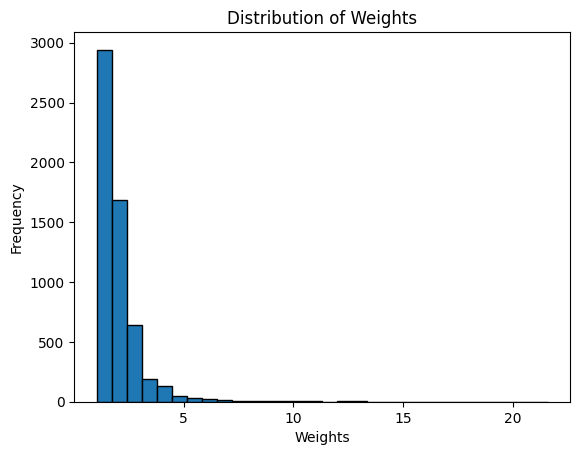

In [12]:
# Step 1: Propensity Score Model using Logistic Regression
X = mydata[xvars]
y = mydata['treatment']
ps_model = sm.Logit(y, sm.add_constant(X)).fit()

# Predicted Propensity Scores
mydata['pscore'] = ps_model.predict(sm.add_constant(X))

# Step 2: Create Inverse Probability of Treatment Weights (IPTW)
mydata['weight'] = np.where(mydata['treatment'] == 1, 1 / mydata['pscore'], 1 / (1 - mydata['pscore']))

# Plot of weights
plt.hist(mydata['weight'], bins=30, edgecolor='black')
plt.title("Distribution of Weights")
plt.xlabel("Weights")
plt.ylabel("Frequency")
plt.show()

In [13]:
# Step 3: Weighted Table for covariate balance
def weighted_mean_std(data, weights, col):
    dsw = DescrStatsW(data[col], weights=weights)
    return dsw.mean, dsw.std

# Create table for covariates and their weighted means and std
for col in xvars:
    treated_mean, treated_std = weighted_mean_std(mydata[mydata['treatment'] == 1], mydata['weight'][mydata['treatment'] == 1], col)
    control_mean, control_std = weighted_mean_std(mydata[mydata['treatment'] == 0], mydata['weight'][mydata['treatment'] == 0], col)
    print(f'{col}: Treated mean (weighted): {treated_mean:.2f}, Control mean (weighted): {control_mean:.2f}')


age: Treated mean (weighted): 61.43, Control mean (weighted): 61.36
female: Treated mean (weighted): 0.45, Control mean (weighted): 0.45
meanbp1: Treated mean (weighted): 79.26, Control mean (weighted): 78.60
ARF: Treated mean (weighted): 0.44, Control mean (weighted): 0.44
CHF: Treated mean (weighted): 0.08, Control mean (weighted): 0.08
Cirr: Treated mean (weighted): 0.04, Control mean (weighted): 0.04
colcan: Treated mean (weighted): 0.00, Control mean (weighted): 0.00
Coma: Treated mean (weighted): 0.07, Control mean (weighted): 0.08
lungcan: Treated mean (weighted): 0.01, Control mean (weighted): 0.01
MOSF: Treated mean (weighted): 0.07, Control mean (weighted): 0.07
sepsis: Treated mean (weighted): 0.22, Control mean (weighted): 0.21


In [20]:

# Step 4: Fit Weighted Models for Outcome
# Causal Risk Difference Model
glm_rd = sm.GLM(mydata['died'], sm.add_constant(mydata['treatment']), family=sm.families.Binomial(link=sm.families.links.identity()), freq_weights=mydata['weight']).fit()
print("Causal Risk Difference:", glm_rd.params[1])

# Causal Relative Risk Model (log link)
glm_rr = sm.GLM(mydata['died'], sm.add_constant(mydata['treatment']), family=sm.families.Binomial(link=sm.families.links.log()), freq_weights=mydata['weight']).fit()
print("Causal Relative Risk:", np.exp(glm_rr.params[1]))


Causal Risk Difference: 0.05154951264962052
Causal Relative Risk: 1.081764435355277


/Users/irene/Library/Python/3.9/lib/python/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(
/Users/irene/Library/Python/3.9/lib/python/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The identity link function does not respect the domain of the Binomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_32950/3000515487.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Causal Risk Difference:", glm_rd.params[1])
/Users/irene/Library/Python/3.9/lib/python/site-packages/statsmodels/genmod/families/links.py:13: FutureW

Causal Risk Difference (truncated): 0.05493243238314589


/Users/irene/Library/Python/3.9/lib/python/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(
/Users/irene/Library/Python/3.9/lib/python/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The identity link function does not respect the domain of the Binomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_32950/673745392.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Causal Risk Difference (truncated):", glm_rd_trunc.params[1])
/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_32950/673745392.py:9: FutureW

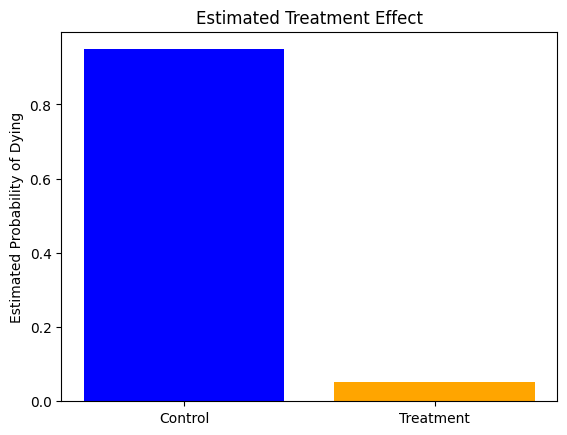

In [21]:

# Step 5: Truncate Weights
mydata['truncated_weight'] = np.where(mydata['weight'] > 10, 10, mydata['weight'])

# Recalculate Causal Risk Difference with truncated weights
glm_rd_trunc = sm.GLM(mydata['died'], sm.add_constant(mydata['treatment']), family=sm.families.Binomial(link=sm.families.links.identity()), freq_weights=mydata['truncated_weight']).fit()
print("Causal Risk Difference (truncated):", glm_rd_trunc.params[1])

# Optional: Visualize the impact of treatment using a bar plot
treatment_effect = glm_rd.params[1]
plt.bar(['Control', 'Treatment'], [1 - treatment_effect, treatment_effect], color=['blue', 'orange'])
plt.title("Estimated Treatment Effect")
plt.ylabel("Estimated Probability of Dying")
plt.show()

In [19]:

# Step 6: IPTW using a Package (if available)
from causalml.propensity import IPTW
iptw = IPTW(model="logistic")
iptw.fit(X, mydata['treatment'])

ImportError: cannot import name 'IPTW' from 'causalml.propensity' (/Users/irene/Library/Python/3.9/lib/python/site-packages/causalml/propensity.py)